In [4]:
from __future__ import print_function
%matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import cv2
from ReconstructOrder.compute.reconstruct import ImgReconstructor
# To install ReconstructOrder from pypi: run $pip install ReconstructOrder
# To install ReconstructOrder from github: clone the repository and then run $pip install -e .

# Forward model: specimen -> Intensity

## Specimen properties

### Case 1: retardance varies from 0 to full-wave

In [6]:
# coordinate grid
x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = 2*np.pi*np.sqrt(xx**2+yy**2)
retardance[retardance >2*np.pi] = 2*np.pi


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 2: retardance constant at half-wave

In [7]:
# coordinate grid

x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = np.pi*np.ones(xx.shape)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 3: retardance constant at quarter-wave 

In [8]:
# coordinate grid

x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = 0.5*np.pi*np.ones(xx.shape)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 4: retardance varies from 0 to less than half-wave

In [9]:
# coordinate grid
x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to less than half-wave (pi/2) 
retardance = 0.2*np.pi*np.sqrt(xx**2+yy**2)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission = np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Plot retardance, slow-axis, transmission, and polarization

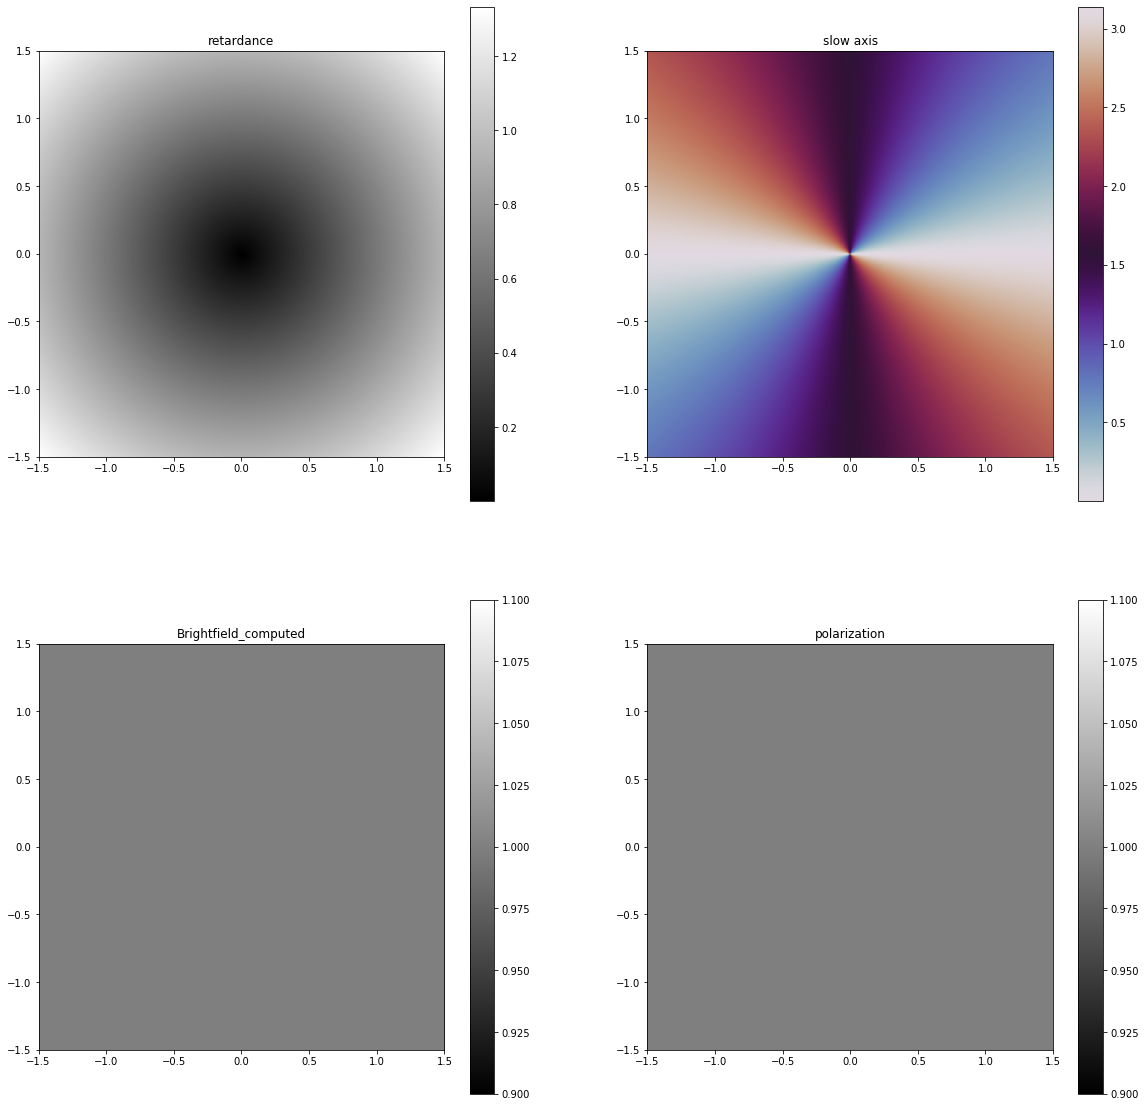

In [10]:
xyextent=[-1.5,1.5,-1.5,1.5]

fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(retardance,cmap='gray',extent=xyextent, origin='lower');
plt.title('retardance')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(slowaxis,cmap='twilight', extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('slow axis')
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(transmission,cmap='gray',extent=xyextent, origin='lower');
plt.title('Brightfield_computed')
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(polarization,cmap='gray',extent=xyextent, origin='lower');
plt.title('polarization')
ax4.figure.colorbar(im);


## Stokes parameters with right circularly polarized illumination

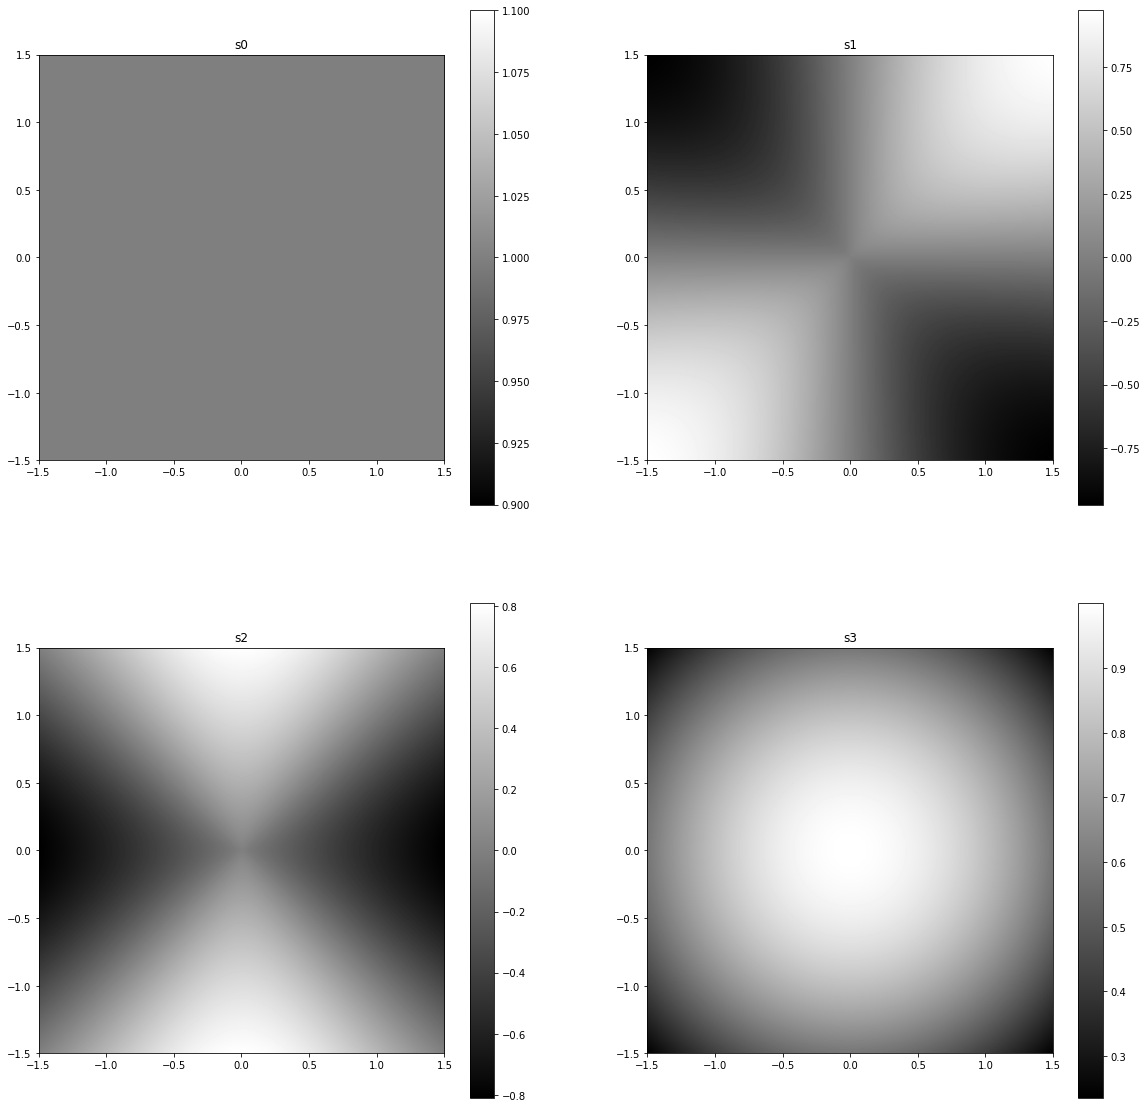

In [11]:
# Assumptions: right circularly polarized input. 
s0=transmission
s1=transmission*polarization*np.sin(2*slowaxis)*np.sin(retardance)
s2=-transmission*polarization*np.cos(2*slowaxis)*np.sin(retardance)
s3=transmission*polarization*np.cos(retardance)

fig2 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig2.add_subplot(2,2,1) 
im=plt.imshow(s0,cmap='gray',extent=xyextent, origin='lower');
plt.title('s0')
ax1.figure.colorbar(im);

ax2=fig2.add_subplot(2,2,2)
im=plt.imshow(s1,cmap='gray',extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('s1')
ax2.figure.colorbar(im);

ax3=fig2.add_subplot(2,2,3)
im=plt.imshow(s2,cmap='gray',extent=xyextent, origin='lower');
plt.title('s2')
ax3.figure.colorbar(im);

ax4=fig2.add_subplot(2,2,4)
im=plt.imshow(s3,cmap='gray',extent=xyextent, origin='lower');
plt.title('s3')
ax4.figure.colorbar(im);

## Intensity images

In [12]:
height,width=s0.shape
s=np.zeros((4,height,width))
s[0,:,:]=s0;  s[1,:,:]=s1; s[2,:,:]=s2; s[3,:,:]=s3;

"""
Swing of 0.25 or quarter-wave leads to linear analysis states. 
Since S1=I0-I90 and S2=I45-I135, the intensity patterns generated by 
"""
swing = 0.05
chi=2*np.pi*swing
StoIMatLC=np.array([ [1, 0, 0, -1],
                     [1, np.sin(chi), 0, -np.cos(chi)],
                     [1, 0, np.sin(chi), -np.cos(chi)],
                     [1, -np.sin(chi), 0, -np.cos(chi)],
                     [1, 0, -np.sin(chi), -np.cos(chi)]])
Svec=s.reshape(4,height*width)
Ivec=np.dot(StoIMatLC,Svec)
I=Ivec.reshape(5,height,width)
Iext=I[0,:,:]; I0=I[1,:,:]; I45=I[2,:,:]; I90=I[3,:,:]; I135=I[4,:,:];

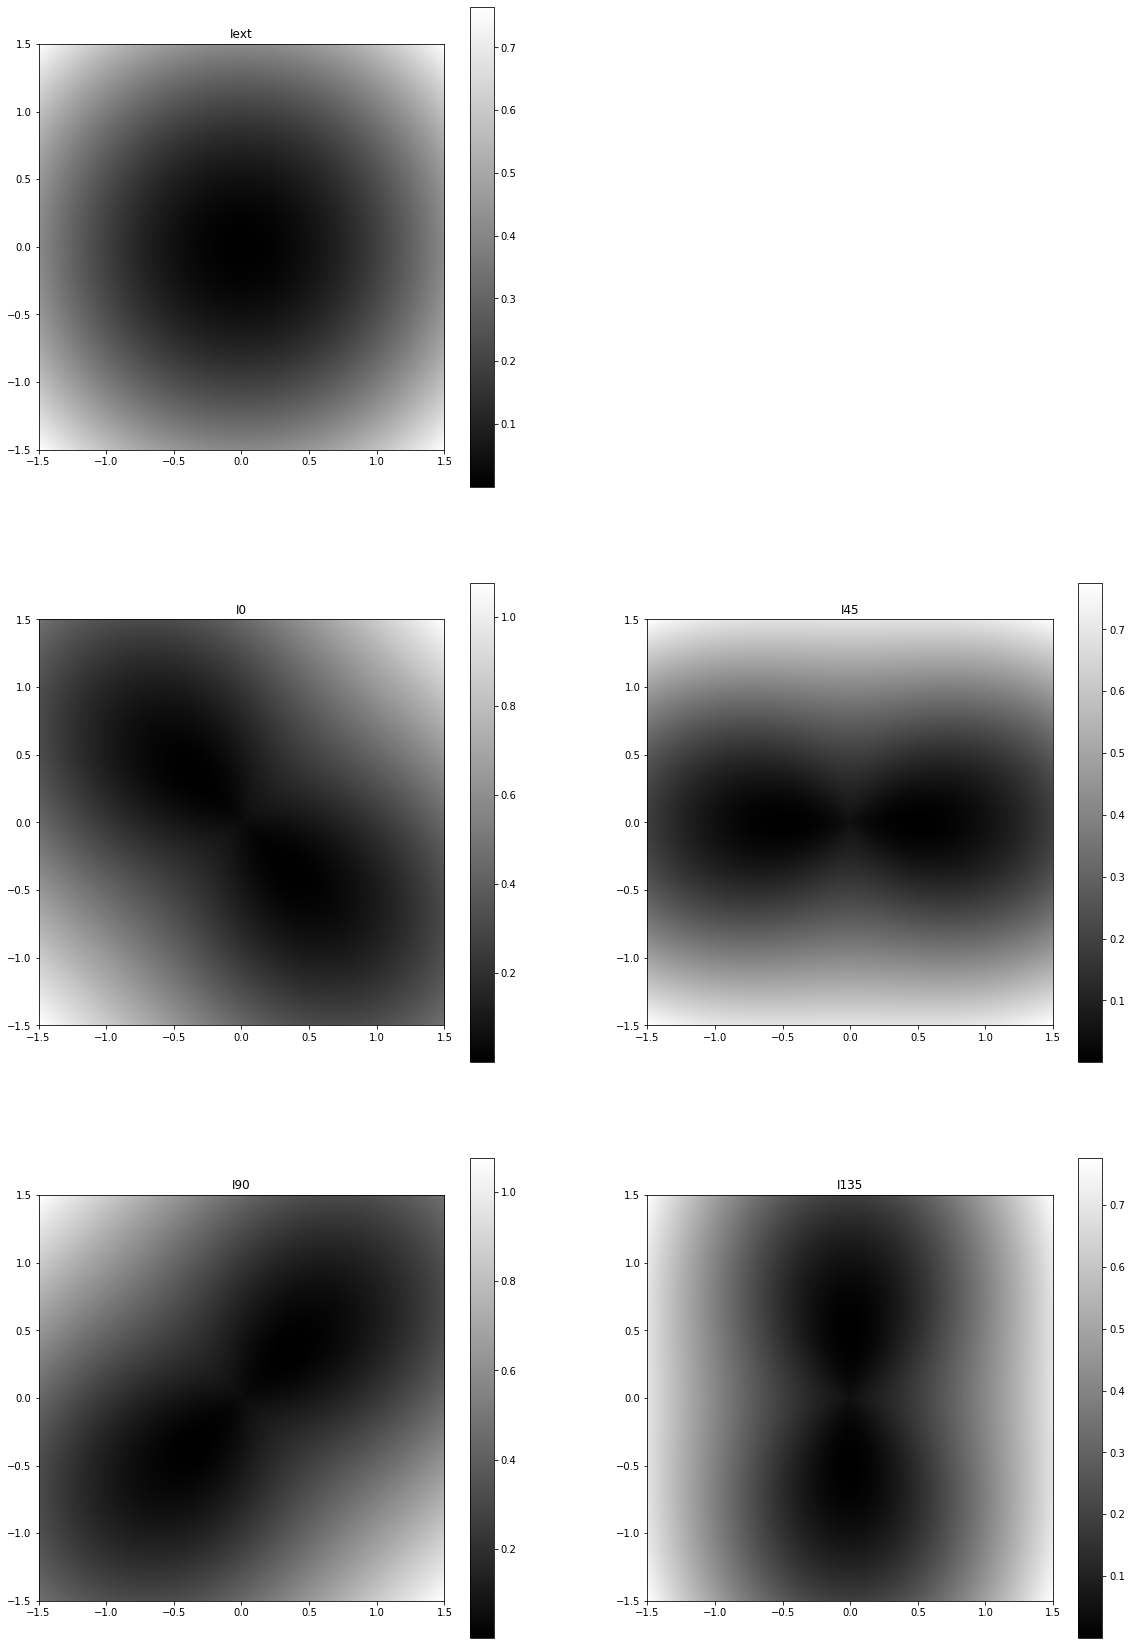

In [13]:
fig3 = plt.figure(figsize=(20,30)) # create a figure with the default size

ax1 = fig3.add_subplot(3,2,1) 
im=plt.imshow(Iext,cmap='gray',extent=xyextent,origin='lower');
plt.title('Iext')
ax1.figure.colorbar(im);

ax2=fig3.add_subplot(3,2,3)
im=plt.imshow(I0,cmap='gray',extent=xyextent,origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('I0')
ax2.figure.colorbar(im);

ax3=fig3.add_subplot(3,2,4)
im=plt.imshow(I45,cmap='gray',extent=xyextent,origin='lower');
plt.title('I45')
ax3.figure.colorbar(im);

ax4=fig3.add_subplot(3,2,5)
im=plt.imshow(I90,cmap='gray',extent=xyextent,origin='lower');
plt.title('I90')
ax4.figure.colorbar(im);

ax5=fig3.add_subplot(3,2,6)
im=plt.imshow(I135,cmap='gray',extent=xyextent,origin='lower');
plt.title('I135')
ax4.figure.colorbar(im);

In [20]:
wavelength = 2 * np.pi
circularity = 'rcp'
# azimuth_offset = 90
azimuth_offset = 0
I=np.dstack((Iext,I0,I45,I90,I135))
img_reconstructor = ImgReconstructor(I.shape,bg_method='Global', swing=swing,
                                         wavelength=wavelength, azimuth_offset = azimuth_offset)

s = img_reconstructor.compute_stokes(I)

[transmission, retardance, slowaxis, polarization] = img_reconstructor.reconstruct_birefringence(
                                                            s, stokes_param_bg=None, circularity=circularity)                                                                                                                            
[s0, s1, s2, s3] = s
# slowaxis = 0.5 * ((np.arctan2(-s1, s2)+ 2*np.pi)%(2*np.pi))+ azimuth_offset  # make azimuth fall in [0,pi]

UnboundLocalError: local variable 'inst_mat' referenced before assignment

In [22]:
print('dynamic range of polarization {}'.format(np.max(polarization)-np.min(polarization)))


dynamic range of polarization 1.0880185641326534e-14


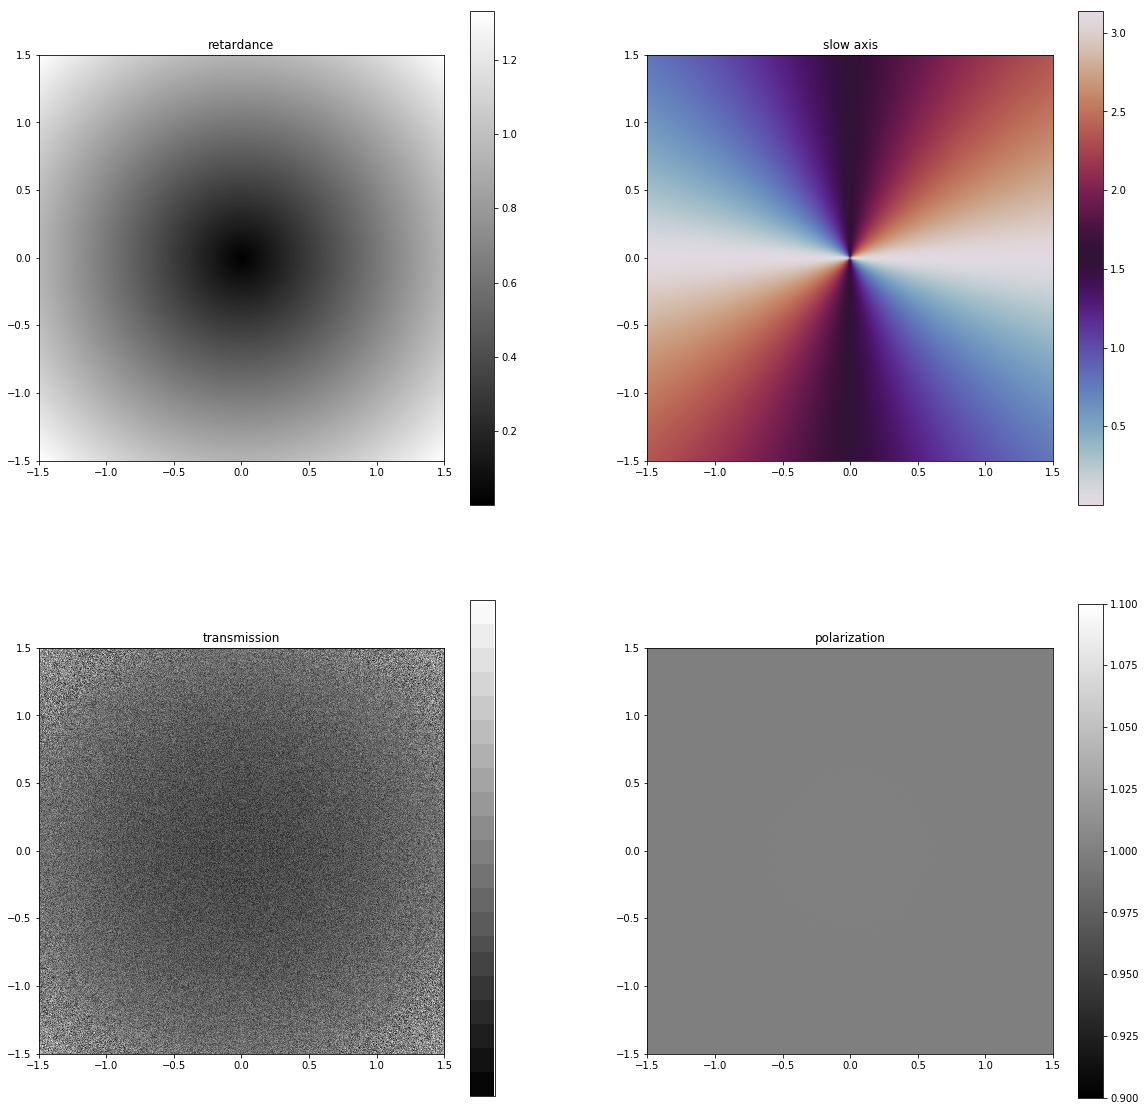

In [23]:
xyextent=[-1.5,1.5,-1.5,1.5]

fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(retardance,cmap='gray',extent=xyextent, origin='lower');
plt.title('retardance')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(slowaxis,cmap='twilight', extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('slow axis')
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(transmission,cmap='gray',extent=xyextent, origin='lower');
plt.title('Brightfield_computed')
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(polarization,cmap='gray',extent=xyextent, origin='lower', vmin=0.9, vmax=1.1);
plt.title('polarization')
ax4.figure.colorbar(im);


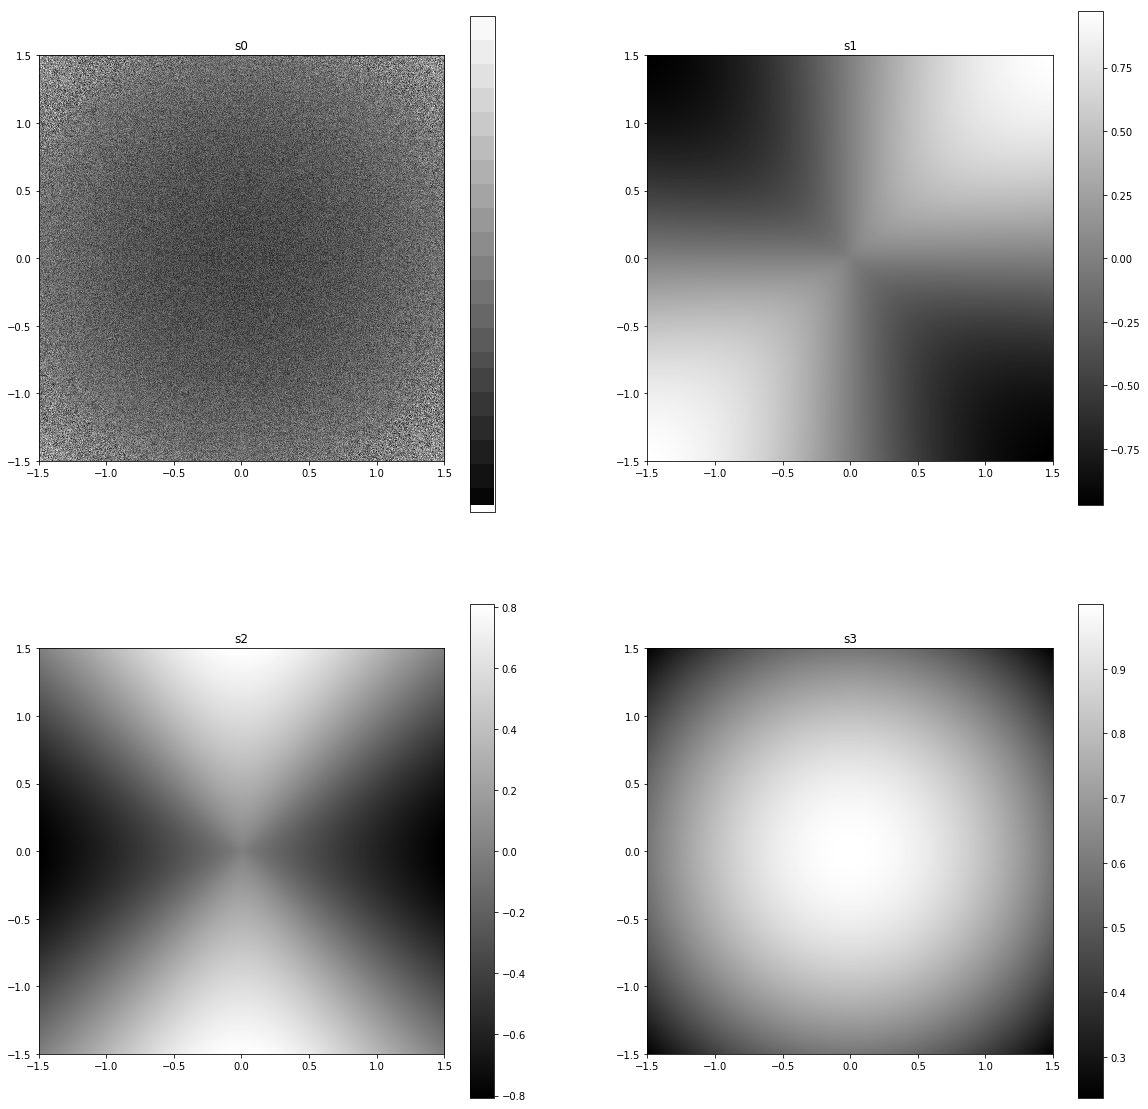

In [24]:
fig2 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig2.add_subplot(2,2,1) 
im=plt.imshow(s0,cmap='gray',extent=xyextent, origin='lower');
plt.title('s0')
ax1.figure.colorbar(im);

ax2=fig2.add_subplot(2,2,2)
im=plt.imshow(s1,cmap='gray',extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('s1')
ax2.figure.colorbar(im);

ax3=fig2.add_subplot(2,2,3)
im=plt.imshow(s2,cmap='gray',extent=xyextent, origin='lower');
plt.title('s2')
ax3.figure.colorbar(im);

ax4=fig2.add_subplot(2,2,4)
im=plt.imshow(s3,cmap='gray',extent=xyextent, origin='lower');
plt.title('s3')
ax4.figure.colorbar(im);